#	How to Run the Code   #
All the libraries needed to run the code are installed through the pip command at runtime in the first code block of the notebook.
The pretrained models are to be retrieved at runtime from huggingface.com, thus an internet connection is required to run the code.
The dataset is included in the repository with the name "dataset.json", but the images are retrieved at runtime from their 
URL, once again needing an internet connection.
The notebook last execution is saved in the repository, thus it contains the execution of each cell (besides the training loop one,
which would have contained 768 images, so it has been cut due to github storing limitations).

#	Paper Review    #

Diffusion models like stable diffusion have reached state of the art capabilities in generating images that are almost indistinguishable from human produced ones. Nevertheless, they are computationally very heavy on the hardware and require hundreds or thousands of diffusion steps in order to produce good results. This iterative infersence process in DMs currently hinders their real-time application due to the number of steps required.

Generative Adversarial Networks (GANs), on the other hand, are characterized by their single-step formulation and inherent speed. Often though, the results produced by GAN training aren’t comparable to the DM ones.

Adversarial Diffusion Distillation (ADD) is a new training approach that constitutes a huge step forward in the context of generative models. It combines the superior sample quality of DMs with the inherent speed of GANs.

The idea is to distill the knowledge of a Diffusion teacher model operating in 1000 steps into a Diffusion student model that operates in just 1-4 steps. This score distillation, using existing image diffusion models as a teaching signal, is combined with an adversarial loss to ensure fidelity in low-step sampling.

ADD surpasses existing few-step methods like GANs and Latent Consistency Models in a single step and equals the performance of SDXL in just four steps, marking a significant advancement in single-step, real-time image synthesis with foundation models.

#	Description of the Method Implemented    #

Our code is an implementation of Adversarial Diffiusion Distillation. The basic idea is to finetune a Diffusion Model in order to achieve comparable performances with less diffusion steps, leveraging a GAN-like training procedure.


Our architecture consists of three pretrained Models:

	-	The Generator (or Student) Model, which generates an image in 4 diffusion steps.
	-	The Teacher model, which generates an image in 100 diffusion steps.
	-	The Discriminator, which classifies if the images (the real one and the one produced by the Generator) are real or generated.
	
The training procedure is structured in the following way:

	-	An image with its caption is retrieved from its url stored in the dataset. 
	-	The Discriminator classifies this image from the dataset as real or generated.
	-	The real image is diffused and transformed into white gaussian noise.
	-	The diffused noise and its caption are fed to the Generator and a new image is
		created in four diffusion steps.
	-	The Discriminator classifies the new image as real or generated.
	-	The new image is diffused and is transformed again into white noise.
	-	The new diffused noise and its captions are fed to the Teacher model and another image is generated in 100 diffusion steps.
	-	The losses are computed and the gradient descent is performed on both the Student and the discriminator models
		
We use different loss functions to train the two models:

	-	The Discriminator is trained on the average Binary Cross Entropy among the results of the classification of the true generated images.
	-	The loss of the Student Model instead is the sum of two components:
			-	The Adversarial loss, that is the BCE between the prediction of the Discriminator for the generated image and the ground true label.
			-	The Distillation loss, that is a Mean Squared Error between the image generated by the Teacher model and the one generated by the Student model.The obtained value is multiplied by a factor l that is set to 5, in order to make it of the same magnitude of the Adversarial loss.

In [1]:
#Install necessary dependencies
%pip install torch torchvision transformers diffusers datasets accelerate torchmetrics torch-fidelity torchmetrics[image]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00


In [2]:
#Import libraries

from transformers import AutoImageProcessor, Dinov2ForImageClassification
from diffusers import DiffusionPipeline
import torch
from diffusers import DPMSolverMultistepScheduler
import requests
import torchvision.transforms as transforms
from PIL import Image
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Pretrained Models

As the discriminator model we used a pretrained Vision Transformer (ViT) model trained using the DINOv2 method. It is a perfect model to be finetuned for our purposes, and similar to the one that gave the best results in the paper.
We added a classification head composed of two fully connected layers and a sigmoid as its final layer in order to make it output values from 0 to 1.
The pretrained model can be retrieved here: https://huggingface.co/facebook/dinov2-small

Both as teacher and as student model we used stable diffusion v2.1. The paper used SDXL, which is a bigger and more complex model, but the ideas at the base of the models remain the same. 
The pretrained model can be retrieved here: https://huggingface.co/stabilityai/stable-diffusion-2-1

In [ ]:
#Initialize the discriminator model

discriminator_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
discriminator_model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-small")

discriminator_model.classifier = torch.nn.Sequential(
    torch.nn.Flatten(),  # Flatten the output
    torch.nn.Linear(768, 256),  # Adjust the input features to match flattened output
    torch.nn.ReLU(),
    torch.nn.Linear(256, 1),
    torch.nn.Sigmoid()
)


In [ ]:
#Initialize the teacher model

teacher_model = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", safety_checker=None, torch_dtype=torch.float16)
teacher_model.scheduler = DPMSolverMultistepScheduler.from_config(teacher_model.scheduler.config)

#Initialize the student model
student_model = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", safety_checker=None, torch_dtype=torch.float16)
student_model.scheduler = DPMSolverMultistepScheduler.from_config(student_model.scheduler.config)

In [6]:
# Move models to the chosen device
student_model = student_model.to(device)
teacher_model = teacher_model.to(device)
print(discriminator_model)


Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
       

## Loss functions

As loss functions the Torch’s implementation of the BCELoss is used as adversarial loss function and the Torch’s implementation of the Mean Squared Error Loss as the distillation loss function. Adam was used to optimize both the student and the discriminator models.

In [7]:
# BCE loss for adversarial loss
adversarial_loss_function = torch.nn.BCELoss()

# MSE loss for distillation loss
distillation_loss_function = torch.nn.MSELoss()
distillation_loss_function.requires_gradient = True
l = 5

# Set up the optimizer for the student and discriminator model
student_optimizer = torch.optim.Adam(student_model.unet.parameters(), lr=0.01)
discriminator_model_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=0.00001)

## Dataset

To train our student model we used a modified version of the COCO 2017 Dataset. The dataset has been modified dropping all the columns aside from the image URL and the caption. All the images are retrieved one by one from their URL at training time in order to reduce the size of the dataset on the disk. All considered, the time necessary for the teacher model to diffuse an image severely outweighs the time needed to retrieve the image.
The COCO (Common Objects in Context) Dataset for Image Captioning is a comprehensive collection that contains over 200,000 labeled images, spanning a diverse range of 80 object categories and over 1 million object instances. These images are rich in everyday scenes, containing common objects in their natural context.


In [8]:
import pandas as pd
from datasets import Dataset

file_path = 'dataset.json'

# Load the JSON file into a DataFrame
dataset = pd.read_json(file_path)
dataset = Dataset.from_pandas(dataset)

#split the dataset into train and validation
dataset = dataset.train_test_split(test_size=0.1)

train_dataset = dataset["train"]
validation_dataset = dataset["test"]

#further split the train dataset into train and test
dataset = train_dataset.train_test_split(test_size=0.1)

train_dataset = dataset["train"]
test_dataset = dataset["test"]

print(train_dataset)
print(validation_dataset)
print(test_dataset)

torch.set_grad_enabled(True)
torch.autograd.set_detect_anomaly(True)

Dataset({
    features: ['image', 'caption'],
    num_rows: 295876
})
Dataset({
    features: ['image', 'caption'],
    num_rows: 239659
})
Dataset({
    features: ['image', 'caption'],
    num_rows: 29588
})
Dataset({
    features: ['image', 'caption'],
    num_rows: 26629
})


In [9]:
# Function to convert an image from a URL to a PyTorch Tensor
def url_to_tensor(url):

    img = Image.open(requests.get(url, stream=True).raw)

    # Define a transform to convert the image to tensor
    transform = transforms.Compose([
        transforms.Resize((768, 768)),  # Resize the image
        transforms.ToTensor()           # Convert the image to a PyTorch Tensor
    ])

    # Apply the transform to the image
    img_tensor = transform(img)

    return img_tensor

# Get the first image in the training dataset
img_tensor = url_to_tensor(train_dataset[0]['image'])

# Print the shape of the image tensor
print(img_tensor.shape)

torch.Size([3, 768, 768])


In [10]:
#Function to plot an image from a tensor
def show_tensor_image(pic):

    # Convert the tensor to a PIL Image
    if (isinstance(pic, torch.Tensor)):
        pil_image = transforms.ToPILImage()(pic)

    else:
        pil_image = pic

    # Display the image
    plt.imshow(pil_image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

#Function that progressively adds gaussian noise to the image
def forward_noise(image, a, s, num_diffusion_steps):

    if (not isinstance(image, torch.Tensor)):
        transform = transforms.ToTensor()
        image = transform(image)

    for i in range(num_diffusion_steps):
        noise = np.random.normal(size=image.shape)  # noise mask
        image = image * a + noise * s

    return image

In [ ]:
import torch
from torchmetrics.multimodal.clip_score import CLIPScore
import os
import pickle
import shutil

#Import clip model in order to compute the clip score
CLIPmetric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")


#Create folder where to save everything on the disk, in order to save ram
save_directory = "saved_data"

if os.path.exists(save_directory):
    shutil.rmtree(save_directory)
    print(f"Deleted existing folder: saved_data")
else:
    print(f"No existing folder found at: saved_data")
    os.makedirs(save_directory)

i=0

#Training loop
for batch in train_dataset:

    i+=1

    image = url_to_tensor(batch["image"])
    caption = batch["caption"]

    # Creating labels for real and fake images
    valid = torch.ones(image.size(0), 1)
    fake = torch.zeros(image.size(0), 1)
    real_image = image

    # Displaying the base image and its caption
    print(f"Epoch {i}, Batch Caption: {caption}")
    show_tensor_image(real_image)

    # Forward diffusion step
    print("Performing forward diffusion...")
    diffused_image = forward_noise(image, a=0.5, s=0.5, num_diffusion_steps=50)

    # Transforming images for distillation loss calculation
    transform = transforms.ToTensor()

    # Generating student image
    print("Generating student image...")
    student_image = student_model(caption, image=diffused_image, height=768, width=768, num_inference_steps=4).images[0]
    student_image_tensor = transform(student_image)
    show_tensor_image(student_image_tensor)

    # Forward diffusion on student image
    print("Forward diffusion on student image...")
    new_diffused_image = forward_noise(student_image, a=0.5, s=0.5, num_diffusion_steps=50)

    # Generating teacher image
    print("Generating teacher image...")
    teacher_image = teacher_model(caption, image=new_diffused_image, height=768, width=768, num_inference_steps=100).images[0]
    teacher_image_tensor = transform(teacher_image)
    show_tensor_image(teacher_image_tensor)

    # Discriminator predictions and loss for real image
    real_pred = discriminator_processor(image, do_rescale=False, return_tensors="pt")
    real_pred = discriminator_model(**real_pred, return_dict=False)

    print(f"real pred = {real_pred}")
    print(f"real_pred[0][0][0] = {real_pred[0][0][0]}]")

    discriminator_real_loss = adversarial_loss_function(real_pred[0][0][0], torch.tensor(1.))
    print(f"Discriminator real Loss: {discriminator_real_loss}")

    # Discriminator predictions and loss for student image
    student_pred = discriminator_processor(student_image, return_tensors="pt")
    student_pred = discriminator_model(**student_pred, return_dict=False)

    print(f"student pred = {student_pred}")
    print(f"student_pred[0][0][0] = {student_pred[0][0][0]}")

    discriminator_fake_loss = adversarial_loss_function(student_pred[0][0][0], torch.tensor(0.))
    student_loss = adversarial_loss_function(student_pred[0][0][0], torch.tensor(1.))

    print(f"Discriminator Fake Loss: {discriminator_fake_loss}")
    print(f"Student Loss: {student_loss}")

    # Calculating adversarial loss
    adversarial_loss = (discriminator_real_loss + discriminator_fake_loss)/2
    print(f"Adversarial Loss: {adversarial_loss}")

    # Computing distillation loss
    distillation_loss = distillation_loss_function(student_image_tensor, teacher_image_tensor)
    distillation_loss.requires_grad = True
    print(f"Distillation Loss: {distillation_loss}")

    #compute the CS score
    print("computing the CS score...")
    clip_score = CLIPmetric(student_image_tensor, caption)
    clip_score.detach()

    print(f"clip_score = {clip_score}")

    # Backpropagation for student model
    student_optimizer.zero_grad()
    student_total_loss = student_loss + l*distillation_loss
    student_total_loss.backward(retain_graph=True)
    student_optimizer.step()

    # Backpropagation for discriminator model
    discriminator_model_optimizer.zero_grad()
    adversarial_loss.backward()
    discriminator_model_optimizer.step()

    # Save real_image and student_image_tensor
    torch.save(real_image, os.path.join(save_directory, f'real_image_{i}.pt'))
    torch.save(student_image_tensor, os.path.join(save_directory, f'student_image_{i}.pt'))

    # Append new losses to the loss files
    with open(os.path.join(save_directory, 'student_losses.pkl'), 'ab') as f:
        pickle.dump([student_loss.item()], f)
    with open(os.path.join(save_directory, 'discriminator_real_losses.pkl'), 'ab') as f:
        pickle.dump([discriminator_real_loss.item()], f)
    with open(os.path.join(save_directory, 'discriminator_fake_losses.pkl'), 'ab') as f:
        pickle.dump([discriminator_fake_loss.item()], f)
    with open(os.path.join(save_directory, 'adversarial_losses.pkl'), 'ab') as f:
        pickle.dump([adversarial_loss.item()], f)
    with open(os.path.join(save_directory, 'distillation_losses.pkl'), 'ab') as f:
        pickle.dump([distillation_loss.item()], f)
    with open(os.path.join(save_directory, 'clip_scores.pkl'), 'ab') as f:
        pickle.dump([clip_score.item()], f)

    #Break the training loop at 256 iterations
    if (i%256 == 0):
        break

    print("End of batch processing.\n")


## Metrics

In order to evaluate the improvement of our model we implemented the same metrics used by the paper, namely the CLIP score and the Frechét Inception Distance. The Fréchet Inception Distance (FID) and CLIP scores are two significant metrics used in evaluating generative models, particularly in the domain of image generation. FID measures the similarity between distributions of generated images and real images, using features extracted by the InceptionV3 model. A lower FID indicates better quality and diversity, resembling real images more closely. Meanwhile, CLIP (Contrastive Language-Image Pretraining) scores assess with the help of a pretrained model the alignment between generated images and their textual descriptions.
Furthermore we plotted the various losses in order to assess the learning of the models.

Unloading models from memory...
Loading data for charts...
Displaying learning graphs...


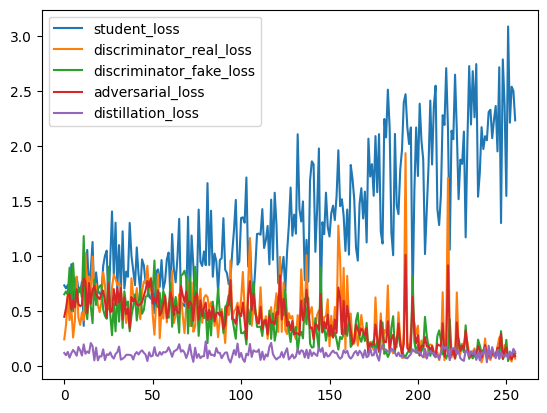

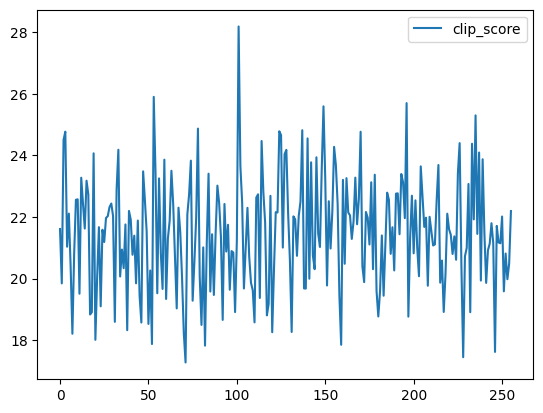

...done
torch.Size([256, 3, 768, 768])
torch.Size([256, 3, 768, 768])
FID: 144.03944396972656


In [3]:
import matplotlib.pyplot as plt
import torch
import pickle
import glob
import gc  # Garbage Collector interface
import os

save_directory = "saved_data"

#Save memory ram by calling the garbage collector on the models
print("Unloading models from memory...")
student_model = None
teacher_model = None
discriminator_model = None

# Explicitly call garbage collector
gc.collect()

# Function to load loss data from pickle files
def load_loss_data(filename):
    data = []
    with open(filename, 'rb') as f:
        while True:
            try:
                data.extend(pickle.load(f))
            except EOFError:
                break
    return data

# Load and plot loss data
print("Displaying learning graphs...")

student_losses = load_loss_data(os.path.join(save_directory, 'student_losses.pkl'))
plt.plot(student_losses, label="student_loss")

discriminator_real_losses = load_loss_data(os.path.join(save_directory, 'discriminator_real_losses.pkl'))
plt.plot(discriminator_real_losses, label="discriminator_real_loss")

discriminator_fake_losses = load_loss_data(os.path.join(save_directory, 'discriminator_fake_losses.pkl'))
plt.plot(discriminator_fake_losses, label="discriminator_fake_loss")

adversarial_losses = load_loss_data(os.path.join(save_directory, 'adversarial_losses.pkl'))
plt.plot(adversarial_losses, label="adversarial_loss")

distillation_losses = load_loss_data(os.path.join(save_directory, 'distillation_losses.pkl'))
plt.plot(distillation_losses, label="distillation_loss")
plt.legend()
plt.show()

clip_scores = load_loss_data(os.path.join(save_directory, 'clip_scores.pkl'))
plt.plot(clip_scores, label="clip_score")
plt.legend()
plt.show()
print("...done")

# Compute the frechet inception distance
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(normalize=True)

# Function to load image tensors
def load_image_tensors(pattern):
    files = glob.glob(pattern)
    tensors = [torch.load(file) for file in sorted(files)]
    return torch.stack(tensors)

real_images = load_image_tensors(os.path.join(save_directory, 'real_image_*.pt'))
print(real_images.shape)

student_images = load_image_tensors(os.path.join(save_directory, 'student_image_*.pt'))
print(student_images.shape)

fid.update(real_images, real=True)
fid.update(student_images, real=False)

print(f"FID: {float(fid.compute())}")

## Commented Results

Due to hardware constraints the results obtained by our execution weren't optimal. Indeed, the original training was performed on batches of 256 images for a total of 1000 epochs. This experimental setup was out of our possibilities. Our training was performed on a 256 epochs with a batch size of 1, spending over 3 hours on Google Colab's free tier GPU. We weren't able to make the student model converge in this short window of training, thus obtaining very high FID and CLIP scores.

Though we had the opportunity to observe some interesting phenomena. In the first part of the training the loss is dominated by the scaled Distllation loss, then the Discriminator begins to effectively recognize generated images leading to a decrease of its loss and an increase of the student's Adversarial loss. This is probably due to a short training time and a concurrent faster speed of learning by the discriminator wrt to the student. 

We performed several attempts to mitigate this problem. We tested several sets of hyperparameters, for example trying to accelerate the learning of the student model by increasing its learning rate, while decreasing the one of thes discriminator model.

We also experimented with several resolutions of the diffused images (being that the paper didn't give out the details in this regard) but quickly realized that whereas the diffusion process would speed up whenever the resolutions where set to low values (e.g. 256x256), the performances of the pretrained teacher model would drastically worsen whenever this resolution was set under 768x768. 

The paper utilizes 1000 diffusion steps for the teacher model. This number of diffusion steps requires around 5 minutes on our configuration, making this process unfeasible. We found out a compromise at 100 diffusion steps, which made the images sufficiently better than the student ones, whereas needing around 30 seconds to be generated.

We also tried to implement a simpler CNN based discriminator model from scratch (whereas the paper suggested, as we did, to use a pretrained ViT). Our naive discriminator though was not able to effectively learn how to recognize the generated images. This is probably due to the fact that the student model was a pretrained diffusion model and although it was using just a few diffusion steps the discriminator wasn't powerful enough to get to learn the differences from real images.

The paper was open to different types of adversarial loss, thus we have experimented with several loss functions such as Hinge Loss, and BCE. In the first case we used the tanh function as the output function of the discriminator in order to map the output from -1 to 1, as needed by the Hinge loss. Though this attempt (and small changes like inserting layernorm or trying rectified tanh) lead to saturation of the output. Therefore after some experiments we switched to a more common BCE.

We experimented several values of the factor l that multiplies the distillation loss, making it ranging from 1 to 20 with the goal of making the impact of this loss more or less impacting on the training of the student model. Along with that we tried to increase the number of diffusion steps of the student model to 10, in order to try and make it more able to fool the discriminator.

The Clip score plot doesn't show an improvement in the alignment between the prompt and the student-generated images through the 256 training epochs. The FID score shows an important disalignment between the real images and the generated ones distributions. This though was kind of expected due to the low amount of images that compose the sets, thus making the distribution approximation not so reliable.

The elevated times necessary to the diffusion models to create images limited severely our experimentation possibilities. One way to work arount this limitaitions would be to precompute the teacher generated images, thus creating a dataset containing caption, original image and generating image. This would speed up the learning process due to the extreme bottleneck caused by the diffusion process of the teacher. Unfortunately such a dataset would have a very specific and restricted kind of usage along with requiring a huge amount of time and resources, thus it hasn't been created yet. 